In [1]:
import pandas as pd
import datetime as dt
import json

import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
plt.style.use('fivethirtyeight')

## Monthly tonnage from NYC Open Data
- data is by community district
- dates back consistently to 2004-ish, but we're focusing on the last decade
- not using 2019 because the year isn't over!

In [2]:
df = pd.read_csv('src/data/monthly_tonnage.csv', na_values='NaN')

## make datetime, separate the year
df.MONTH = pd.to_datetime(df.MONTH)
df['year'] = df.MONTH.astype(str).str.extract(r'^(.*)-.*-.*').astype(int)
df.BOROUGH_ID = df.BOROUGH_ID.astype(str)

df = df[df.year > 2008] ## just for the past 10 years

## some math to get the percents and totals
df['total_recycled'] = df.PAPERTONSCOLLECTED + df.MGPTONSCOLLECTED
df['percent_recycled'] = df['total_recycled'] / df.REFUSETONSCOLLECTED

# give the borough code
def get_boro_code(x):
    return x.BOROUGH_ID + "{:02d}".format(x.COMMUNITYDISTRICT)
df['borough_code'] = df.apply(get_boro_code, axis=1)

In [3]:
## a preview of our data
df.head(3)

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID,year,total_recycled,percent_recycled,borough_code
3,2012-03-01,Manhattan,1,1194.4,341.6,210.8,NaN,NaN,NaN,NaN,1,2012,552.4,0.462492,101
9,2012-01-01,Brooklyn,7,3156.7,436.6,343.4,NaN,NaN,NaN,20.1,3,2012,780.0,0.247093,307
13,2016-11-01,Brooklyn,7,3356.9,424.4,380.3,120.1,NaN,2.5,NaN,3,2016,804.7,0.239715,307


## The hierarchy of boroughs that recycle the most of their waste hasn't changed

In [4]:
recycled_2018_df = df[df.year == 2018].groupby('BOROUGH').percent_recycled.mean().reset_index()
recycled_2009_df = df[df.year == 2009].groupby('BOROUGH').percent_recycled.mean().reset_index()

print('Boroughs that recycled the highest percentage of their waste from 2018')
print(recycled_2018_df.sort_values('percent_recycled', ascending=False))
print('\n')
print('Boroughs that recycled the highest percentage of their waste from 2009')
print(recycled_2009_df.sort_values('percent_recycled', ascending=False))

Boroughs that recycled the highest percentage of their waste from 2018
         BOROUGH  percent_recycled
2  Manhattan      0.310225        
4  Staten Island  0.256344        
3  Queens         0.244487        
1  Brooklyn       0.224451        
0  Bronx          0.187468        


Boroughs that recycled the highest percentage of their waste from 2009
         BOROUGH  percent_recycled
2  Manhattan      0.288883        
4  Staten Island  0.256694        
3  Queens         0.220350        
1  Brooklyn       0.200168        
0  Bronx          0.140134        


### Some math to calculate changes over time

In [5]:
bydist_2018 = df[df['year']==2018].groupby('borough_code').percent_recycled.mean().reset_index()
bydist_2009 = df[df['year']==2009].groupby('borough_code').percent_recycled.mean().reset_index()

bydist = pd.merge(bydist_2018,bydist_2009['percent_recycled'],left_index=True,right_index=True)
bydist.columns = ['borough_code','pct_recyc_2018','pct_recyc_2009']
bydist['pct_change'] = bydist['pct_recyc_2018'] / bydist['pct_recyc_2009'] - 1
bydist['pct_point_change'] = bydist['pct_recyc_2018'] - bydist['pct_recyc_2009']
bydist.to_csv('10-year-change.csv', index=False)

## But when checking out changes over the decades by individual districts, the Bronx leads the way

In [6]:
print('The community districts with the greatest percentage point increases are mostly in the Bronx (2**)')
bydist.sort_values('pct_change', ascending=False).head()

The community districts with the greatest percentage point increases are mostly in the Bronx (2**)


,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change
14,203,0.150308,0.083908,0.791348,0.066400
13,202,0.165163,0.097582,0.692550,0.067580
15,204,0.138580,0.083743,0.654833,0.054837
9,110,0.186162,0.116931,0.592069,0.069231
27,304,0.201336,0.126831,0.587433,0.074505


In [7]:
print('The community districts with the lowest percentage point decreases are mostly in Mahattan (1**), Brooklyn (3**) and Staten Island (5**)')
bydist.sort_values('pct_change', ascending=True).head()

The community districts with the lowest percentage point decreases are mostly in Mahattan (1**), Brooklyn (3**) and Staten Island (5**)


,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change,pct_point_change
0,101,0.457068,0.525482,-0.130192,-0.068414
5,106,0.341653,0.390732,-0.125609,-0.049079
58,503,0.260752,0.273779,-0.047583,-0.013027
34,311,0.228816,0.237253,-0.035561,-0.008437
41,318,0.211713,0.218775,-0.032279,-0.007062


In [8]:
# opening the community-districts json from NYC Open Data
with open('src/data/community-districts.json') as f:
    data = json.load(f)

### One Dataset to Rule Them All 

It has demographic data from NYC Open Data (originally pulled from the Census), the Monthly Tonnage Data, and the math we did to calculate change over time

In [48]:
df = pd.read_csv('src/data/joined_and_tonnage.csv')
df = df[df.year == 2018].groupby('boro_cd')

### The districts with the highest poverty rate have among the highest percentage increase in recycling in the last decade

The Bronx takes up 6 of the 10 districts with the greatest increase, with each of the 6 districts having a higher poverty rate than the others

In [101]:
poverty_df = df['pct_change'].median().reset_index().merge(df['poverty_rate'].median().reset_index(), on='boro_cd')

In [107]:
print('The median poverty rate of the top 10 districts with the greatest recycling percent increase is ' + poverty_df.sort_values('pct_change', ascending=False).head(10).poverty_rate.median().astype(str) + '%')

poverty_df.sort_values('pct_change', ascending=False).head(10)


The median poverty rate of the top 10 districts with the greatest recycling percent increase is 28.85%


,boro_cd,pct_change,poverty_rate
14,203,0.791348,30.3
13,202,0.692550,31.0
15,204,0.654833,32.4
9,110,0.592069,20.2
27,304,0.587433,24.8
12,201,0.564129,31.0
26,303,0.501920,21.2
17,206,0.450958,30.3
18,207,0.418248,27.4
8,109,0.405321,20.7


### Districts with the greatest decrease have a lower poverty rate

In [111]:
print('The median poverty rate of the top 10 districts with the greatest recycling percent decrease is ' + poverty_df.sort_values('pct_change').head(10).poverty_rate.median().astype(str) + '%')

print('\nNine of these 10 districts are recycling less than they were a decade ago, indicated by a negative pct_change column.')

poverty_df.sort_values('pct_change', ascending=True).head(10)


The median poverty rate of the top 10 districts with the greatest recycling percent decrease is 14.75%

Nine of these 10 districts are recycling less than they were a decade ago, indicated by a negative pct_change column.


,boro_cd,pct_change,poverty_rate
0,101,-0.130192,8.8
5,106,-0.125609,9.8
58,503,-0.047583,12.3
34,311,-0.035561,22.5
41,318,-0.032279,14.6
57,502,-0.017405,14.9
38,315,-0.016391,18.6
3,104,-0.012255,11.3
35,312,-0.001836,27.2
49,408,0.018412,20.8


In [125]:
print("Districts with a poverty rate above 25 percent have an average increase of " + (poverty_df[poverty_df.poverty_rate > 25]['pct_change'].median() * 100).astype(str) + '%')

print("\nDistricts with a poverty rate below 10 percent have an average increase of " + (poverty_df[poverty_df.poverty_rate < 10]['pct_change'].median() * 100).astype(str) + '%')

Districts with a poverty rate above 25 percent have an average increase of 32.701870475246565%

Districts with a poverty rate below 10 percent have an average increase of 9.741899582355561%


<hr>

## 311 data regarding missed recyling collections

Data is <code>311_Service_Requests_from_2010_to_Present.csv</code>

I grabbed and filtered the data on NYC Open Data and filtered it to only include DSNY complaints mentioning recycling

In [180]:
df_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', usecols=['Unique Key', 'Created Date', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor','Location Type', 'Incident Zip', 'Incident Address', 'Street Name', 'City', 'Resolution Description', 'Community Board', 'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Latitude', 'Longitude', 'Borough'])
df_311['year'] = df_311['Created Date'].str.extract('\d+\/\d+\/(\d+)') ## this grabs the year

In [181]:
df_311.head(1)

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,City,Resolution Description,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Latitude,Longitude,year
0,44916024,11/13/2019 10:19:00 AM,DSNY,BCC - Queens West,Missed Collection (All Materials),1R Missed Recycling-All Materials,Sidewalk,11378.0,59-15 69 LANE,69 LANE,Maspeth,The Department of Sanitation is in the process...,05 QUEENS,QUEENS,1014336.0,203004.0,40.723825,-73.891457,2019


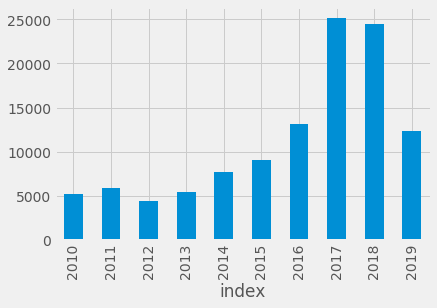

In [182]:
df_311.year.value_counts().reset_index().sort_values('index', ascending=True).plot(kind='bar', x='index', y='year', legend=False)

In [183]:
df_311['Community Board'].value_counts().head(10)

01 STATEN ISLAND    14443
03 STATEN ISLAND    13643
02 STATEN ISLAND     9859
01 BROOKLYN          5280
07 QUEENS            4791
12 BROOKLYN          3307
13 QUEENS            3241
03 BROOKLYN          2706
08 QUEENS            2661
12 QUEENS            2604
Name: Community Board, dtype: int64

In [186]:
df_311['Borough'].value_counts().head(6)

STATEN ISLAND    37952
BROOKLYN         32470
QUEENS           27294
MANHATTAN         8435
BRONX             6690
Unspecified          8
Name: Borough, dtype: int64

#Different Drop off locations

In [39]:
textile=pd.read_csv('Textile_Drop-Off_Locations_in_NYC.csv')
textile

,Address,BBL,BIN,BoroCD,Borough,CT2010,CouncilDistrict,Items_Accepted,Latitude,Longitude,...,Unit,Vendor_Name,Website,point,zipcode,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,606 E 89 St,3079930000,3224082,318,Brooklyn,964,46,"Clothing, Shoes, Accessories, Coats, Bedding A...",40.64240,-73.90993,...,NaN,Christian Church Of Canarsie,https://www1.nyc.gov/assets/donate/giveandfind...,POINT (-73.909932 40.642403),11236,13827,5.0,2.0,8.0,42.0
1,1133 Ogden Ave,2025260000,2088158,204,Bronx,199,16,"Clothing, Shoes",40.83659,-73.92780,...,NaN,Usagain LLC,http://www.usagain.com/,POINT (-73.927801 40.836595),10452,10930,50.0,5.0,42.0,27.0
2,10 Cebra Ave,5001150000,5002741,501,Staten Island,75,49,"Clothing, Shoes",40.63412,-74.08648,...,NaN,Planet Aid,http://www.planetaid.org/,POINT (-74.086477 40.63412199999999),10301,10369,4.0,1.0,13.0,74.0
3,1169 Bay St,5028290000,5107418,501,Staten Island,6,49,"Clothing, Shoes, Accessories",40.61481,-74.06644,...,NaN,Community Recycling LLC,https://www.communityrecycling.biz/,POINT (-74.066443 40.614809),10305,10692,4.0,1.0,13.0,74.0
4,137-42 Guy R Brewer Blvd,4123090000,4266757,412,Queens,294,28,"Clothing, Shoes, Accessories, Bedding and line...",40.67093,-73.77412,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.774124 40.670926),11434,24669,41.0,3.0,46.0,71.0
5,4844 Hylan Blvd,5063980000,5082010,503,Staten Island,176,51,"Clothing, Shoes, Coats, Accessories, Bedding, ...",40.52655,-74.16738,...,NaN,American Recycling Technologies Inc.,http://www.americanrecyclingtech.com/,POINT (-74.167381 40.526554),10312,10699,15.0,1.0,9.0,77.0
6,611 Grand Concourse,2023480000,2001076,204,Bronx,63,8,"Clothing, Shoes, Accessories, Bedding and line...",40.82045,-73.92674,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.926739 40.82045500000001),10451,10929,50.0,5.0,35.0,27.0
7,50-15 Roosevelt Ave,4013190000,4030851,402,Queens,25302,26,"Clothing, Shoes, Coats, Towels",40.74403,-73.91456,...,NaN,Carecycle Inc,carecyclecares.com/,POINT (-73.914562 40.74403),11377,14787,53.0,3.0,33.0,66.0
8,77-00 Queens Blvd,4024520000,4056456,404,Queens,479,25,"Clothing, Shoes, Accessories",40.73808,-73.88610,...,NaN,Community Recycling LLC,https://www.communityrecycling.biz/,POINT (-73.886102 40.738083),11373,14784,66.0,3.0,5.0,68.0
9,1809 Utica Ave,3077980000,3216426,318,Brooklyn,730,46,"Clothing, Shoes, Accessories, Bedding and line...",40.62799,-73.92747,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.927472 40.62798999999998),11234,13825,5.0,2.0,8.0,38.0


In [65]:
bins=textile.BoroCD.value_counts().reset_index()
bins = bins.rename(columns={'index': 'BoroCD','BoroCD':'No.BoroCD'})
bins.head(3)

,BoroCD,No.BoroCD
0,501,59
1,412,57
2,318,43


In [91]:
borou=textile.Borough.value_counts().reset_index()
borou = borou.rename(columns={'index': 'Borough','Borough':'No_Borough'})
borou.head(5)

,Borough,No_Borough
0,Brooklyn,325
1,Queens,293
2,Manhattan,206
3,Bronx,205
4,Staten Island,112


In [72]:
prc=pd.read_csv('10-year-change.csv')
prc = prc.rename(columns={'borough_code': 'BoroCD'})
prc.head(5)

,BoroCD,pct_recyc_2018,pct_recyc_2009,pct_change
0,101,0.457068,0.525482,-0.130192
1,102,0.405030,0.357676,0.132396
2,103,0.220118,0.209310,0.051639
3,104,0.372049,0.376665,-0.012255
4,105,0.346514,0.334442,0.036097


In [75]:
join=bins.merge(prc, on='BoroCD')
join.head(5)

,BoroCD,No.BoroCD,pct_recyc_2018,pct_recyc_2009,pct_change
0,501,59,0.251563,0.235038,0.070306
1,412,57,0.193020,0.165567,0.165812
2,318,43,0.211713,0.218775,-0.032279
3,209,43,0.141494,0.102497,0.380468
4,305,41,0.141763,0.135917,0.043010


In [ ]:
secondjoin=join.merge(borou,on)

In [82]:
join.to_csv('bin-and-pct.csv')

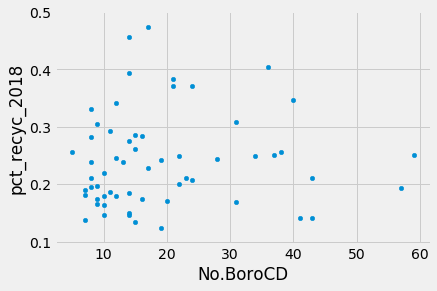

In [81]:
fig=join.plot(kind='scatter',x='No.BoroCD',y='pct_recyc_2018')